In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 2.6MB/s 
     |████████████████████████████████| 3.8MB 12.5MB/s 
     |████████████████████████████████| 1.0MB 32.0MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/121-distilroBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [7]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_1.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_2.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_5.tar.gz'

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/distilroberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/distilroberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 128,
  "EPOCHS": 70,
  "LEARNING_RATE": 1e-4,
  "ES_PATIENCE": None,
  "question_size": 4,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'distilroberta-base-tf_model.h5',
  "config_path": base_path + 'distilroberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 0.0001 to 0.0001 to 2.45e-06


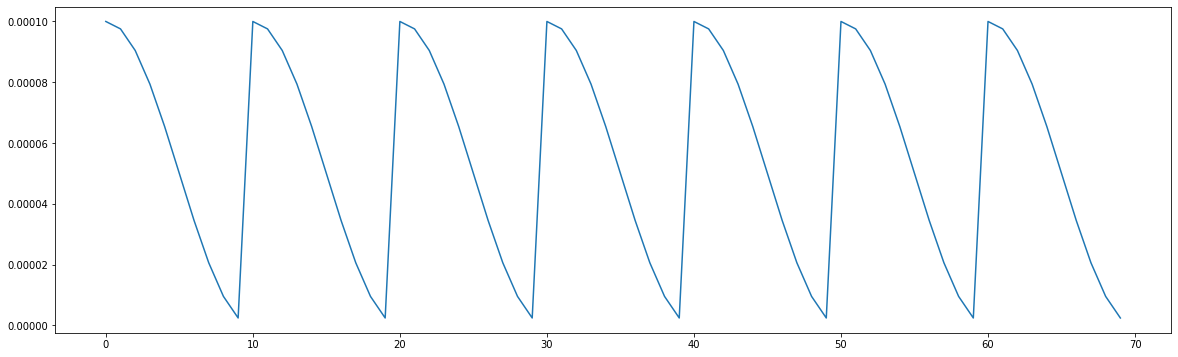

In [19]:
LR_MIN = 1e-7
LR_MAX = config['LEARNING_RATE']
lr_start=1e-4
warmup_epochs=0
hold_max_epochs=0
num_cycles=config['EPOCHS'] // 10
total_epochs = config['EPOCHS']

@tf.function()
def lrfn(epoch):
    if epoch < warmup_epochs:
        lr = (LR_MAX - lr_start) / (warmup_epochs * epoch + lr_start)
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        # if LR_MIN is not None:
        #     lr = max(LR_MIN, lr)
            
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _  = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})

    # x = layers.Dropout(.1)(last_hidden_state)
    
    x_start = layers.Dense(1)(last_hidden_state)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dense(1)(last_hidden_state)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.1)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.1)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_acc_start.update_state(y['y_start'], probabilities)
            train_acc_end.update_state(y['y_end'], probabilities)
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_acc_start.update_state(y['y_start'], probabilities)
            valid_acc_end.update_state(y['y_end'], probabilities)
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_acc_start = metrics.CategoricalAccuracy()
    valid_acc_start = metrics.CategoricalAccuracy()
    train_acc_end = metrics.CategoricalAccuracy()
    valid_acc_end = metrics.CategoricalAccuracy()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'acc_start': train_acc_start, 'acc_end': train_acc_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end, 
                    'val_acc_start': valid_acc_start, 'val_acc_end': valid_acc_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         model_path, save_last=True)
    
    history_list.append(history)
    # model.load_weights(model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/70
time: 148.9s loss: 3.3209 loss_start: 1.6685 loss_end: 1.6524 acc_start: 0.3908 acc_end: 0.3971 val_loss: 1.8265 val_loss_start: 0.9396 val_loss_end: 0.8869 val_acc_start: 0.4320 val_acc_end: 0.4255

EPOCH 2/70
time: 140.5s loss: 2.9165 loss_start: 1.4795 loss_end: 1.4370 acc_start: 0.4249 acc_end: 0.4343 val_loss: 1.8055 val_loss_start: 0.9650 val_loss_end: 0.8406 val_acc_start: 0.4245 val_acc_end: 0.4244

EPOCH 3/70
time: 140.5s loss: 2.7108 loss_start: 1.3795 loss_end: 1.3313 acc_start: 0.4433 acc_end: 0.4528 val_loss: 1.8323 val_loss_start: 0.9503 val_loss_end: 0.8820 val_acc_start: 0.4392 val_acc_end: 0.4306

EPOCH 4/70
time: 140.5s loss: 2.4990 loss_start: 1.2735 loss_end: 1.2254 acc_start: 0.4673 acc_end: 0.4779 val_loss: 1.9620 val_loss_start: 1.0322 val_loss_end: 0.9298 val_acc_start: 0.4024 val_acc_end: 0.4125

EPOCH 5/70
time: 140.4s loss: 2.2741 loss_start: 1.1551 loss_end: 1.1190 acc_start: 0.4942 acc_end: 0.

# Model loss graph

Fold: 1


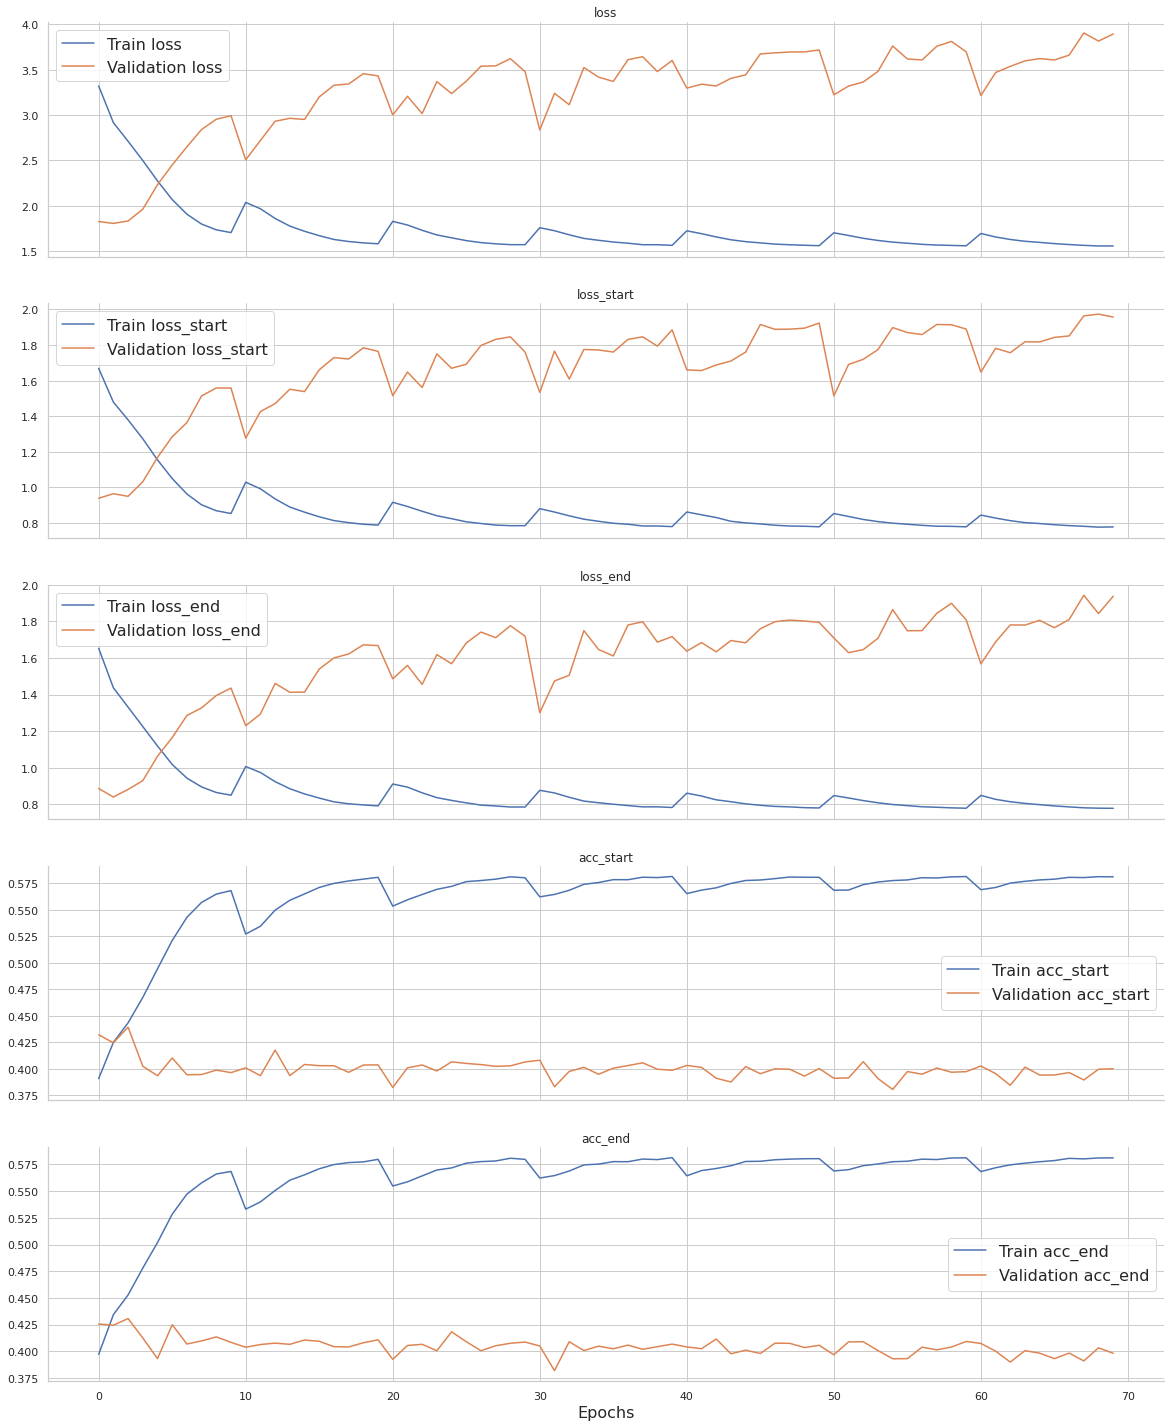

In [23]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [24]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric/Jaccard,,,,,
Overall,0.950181,0.675745,0.274436,0.950181,0.675745
Sentiment negative,0.924229,0.468997,0.455231,0.924229,0.468997
Sentiment neutral,0.991929,0.972024,0.019905,0.991929,0.972024
Sentiment positive,0.919637,0.479226,0.440411,0.919637,0.479226
0 <= text wordCnt < 3,0.919872,0.838308,0.081563,0.919872,0.838308
3 <= text wordCnt < 10,0.963283,0.729296,0.233987,0.963283,0.729296
10 <= text wordCnt < 30,0.944543,0.640008,0.304535,0.944543,0.640008
30 <= text wordCnt < 100,0.946251,0.663829,0.282423,0.946251,0.663829
0 <= selected text wordCnt < 3,0.907443,0.512345,0.395098,0.907443,0.512345


# Visualize predictions

In [25]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.0
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sad,0.5
2,my boss is bullying me...,bullying me,negative,bullying me,1.0
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.0
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",1.0
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.0
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.0
7,soooo high,soooo high,neutral,soooo high,1.0
8,both of you,both of you,neutral,both of you,1.0
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow... u just became cooler.,1.0
